## **Introduction:**

**Prediction Quesiton**: Were Asian Americans more likely to be attacked in cities/towns with a higher amount of Covid cases due to rise in xenophobia during the Pandemic?

**Importance for client**: This research question can guide law enforcement in the future. Even though there may not be the same case of anti-asian hate, there will most likely be more xenophobia in the future. By analyzing this data, we can see if there was actually a rise during the pandemic of attacks on asian americans, and then law enforcement can protect groups in a similar scenario in the future.

## **Setting Up Data for Model Training:**

In [42]:
# Setting up environment:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# loading in dataset as dataframe:
# WARNING: we cleaned the dataset in prior iterations of the project.
# We included specific years of 2016 - 2023 and only "Murder and non-negligent manslaughter"
df = pd.read_csv("cleaned_df.csv")
print(df.shape)

# previewing the data:
# df.head(5)
df.columns

(13794, 21)


Index(['Unnamed: 0', 'State', 'Agency', 'Source', 'Solved', 'Year', 'Month',
       'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'VicCount', 'OffCount'],
      dtype='object')

In [44]:
# selecting relevant columns to use for model analysis:
df_new = df[['Year', 'Month', 'State', 'OffRace', 'OffAge', 'Situation', 'VicRace']]
# df_new.head(5)

In [45]:
# checking for NaNs:
print(df_new.isna().sum())

# dropping missing values for 'OffRace' since can not impute for categorical:
# df_new = df_new.dropna(subset=['OffRace'], axis=0)
df_new['OffRace'] = df_new["OffRace"].fillna('Unknown')


# imputing missing values for 'OffAge' with median:
df_new['OffAge'] = df_new['OffAge'].fillna(df_new['OffAge'].median())

# imputing missing values for 'VicRace' with 'Unknown':
df_new['VicRace'] = df_new['VicRace'].fillna('Unknown')

# previewing new/cleaned dataframe:
print(df_new.head())
print(df_new.isna().sum())

Year            0
Month           0
State           0
OffRace      4413
OffAge       4441
Situation       0
VicRace       210
dtype: int64
   Year    Month   State                            OffRace  OffAge  \
0  2016  January  Alaska  American Indian or Alaskan Native    21.0   
1  2016  January  Alaska                              White    15.0   
2  2016  January  Alaska                              White    15.0   
3  2016  January  Alaska                              White    34.0   
4  2016  January  Alaska  American Indian or Alaskan Native    33.0   

                          Situation                            VicRace  
0     Single victim/single offender  American Indian or Alaskan Native  
1  Multiple victims/single offender                              White  
2  Multiple victims/single offender                              White  
3  Single victim/multiple offenders  American Indian or Alaskan Native  
4     Single victim/single offender  American Indian or Alaskan Nativ

/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['OffRace'] = df_new["OffRace"].fillna('Unknown')
/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['OffAge'] = df_new['OffAge'].fillna(df_new['OffAge'].median())
/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:13: SettingWithCopyWarning: 
A value is trying to 

**One Hot Encoding Data for Model:**

In [46]:
# separating numerical and categorical columns:

# numerical columns:
num_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# categorical columns:
cat_cols = df_new.select_dtypes(exclude=[np.number]).columns.tolist()
# cat_cols.remove('VicRace')
print(cat_cols)

['Year', 'OffAge']
['Month', 'State', 'OffRace', 'Situation', 'VicRace']


In [47]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#splitting the data to before and after 2020
df_pre_covid = df_new[df_new['Year']<2020]
df_post_covid = df_new[df_new['Year']>=2020]

y_pre = df_pre_covid['VicRace']
y_post = df_post_covid['VicRace']

X_raw_pre = df_pre_covid.drop(columns=['VicRace'])
X_raw_post = df_post_covid.drop(columns=['VicRace'])

# one hot encoding categorical features:
X_pre = pd.get_dummies(X_raw_pre, drop_first=True)
X_post = pd.get_dummies(X_raw_post, drop_first = True)

# splitting data into test/train:
X_train_pre, X_test_pre, Y_train_pre, Y_test_pre = train_test_split(X_pre, y_pre, test_size=0.2, random_state=42)
X_train_post, X_test_post, Y_train_post, Y_test_post = train_test_split(X_post, y_post, test_size=0.2, random_state=42)

## **Training the PRE-Covid Model:**

Best min_sample_leaf value: 24 with Accuracy of 0.741


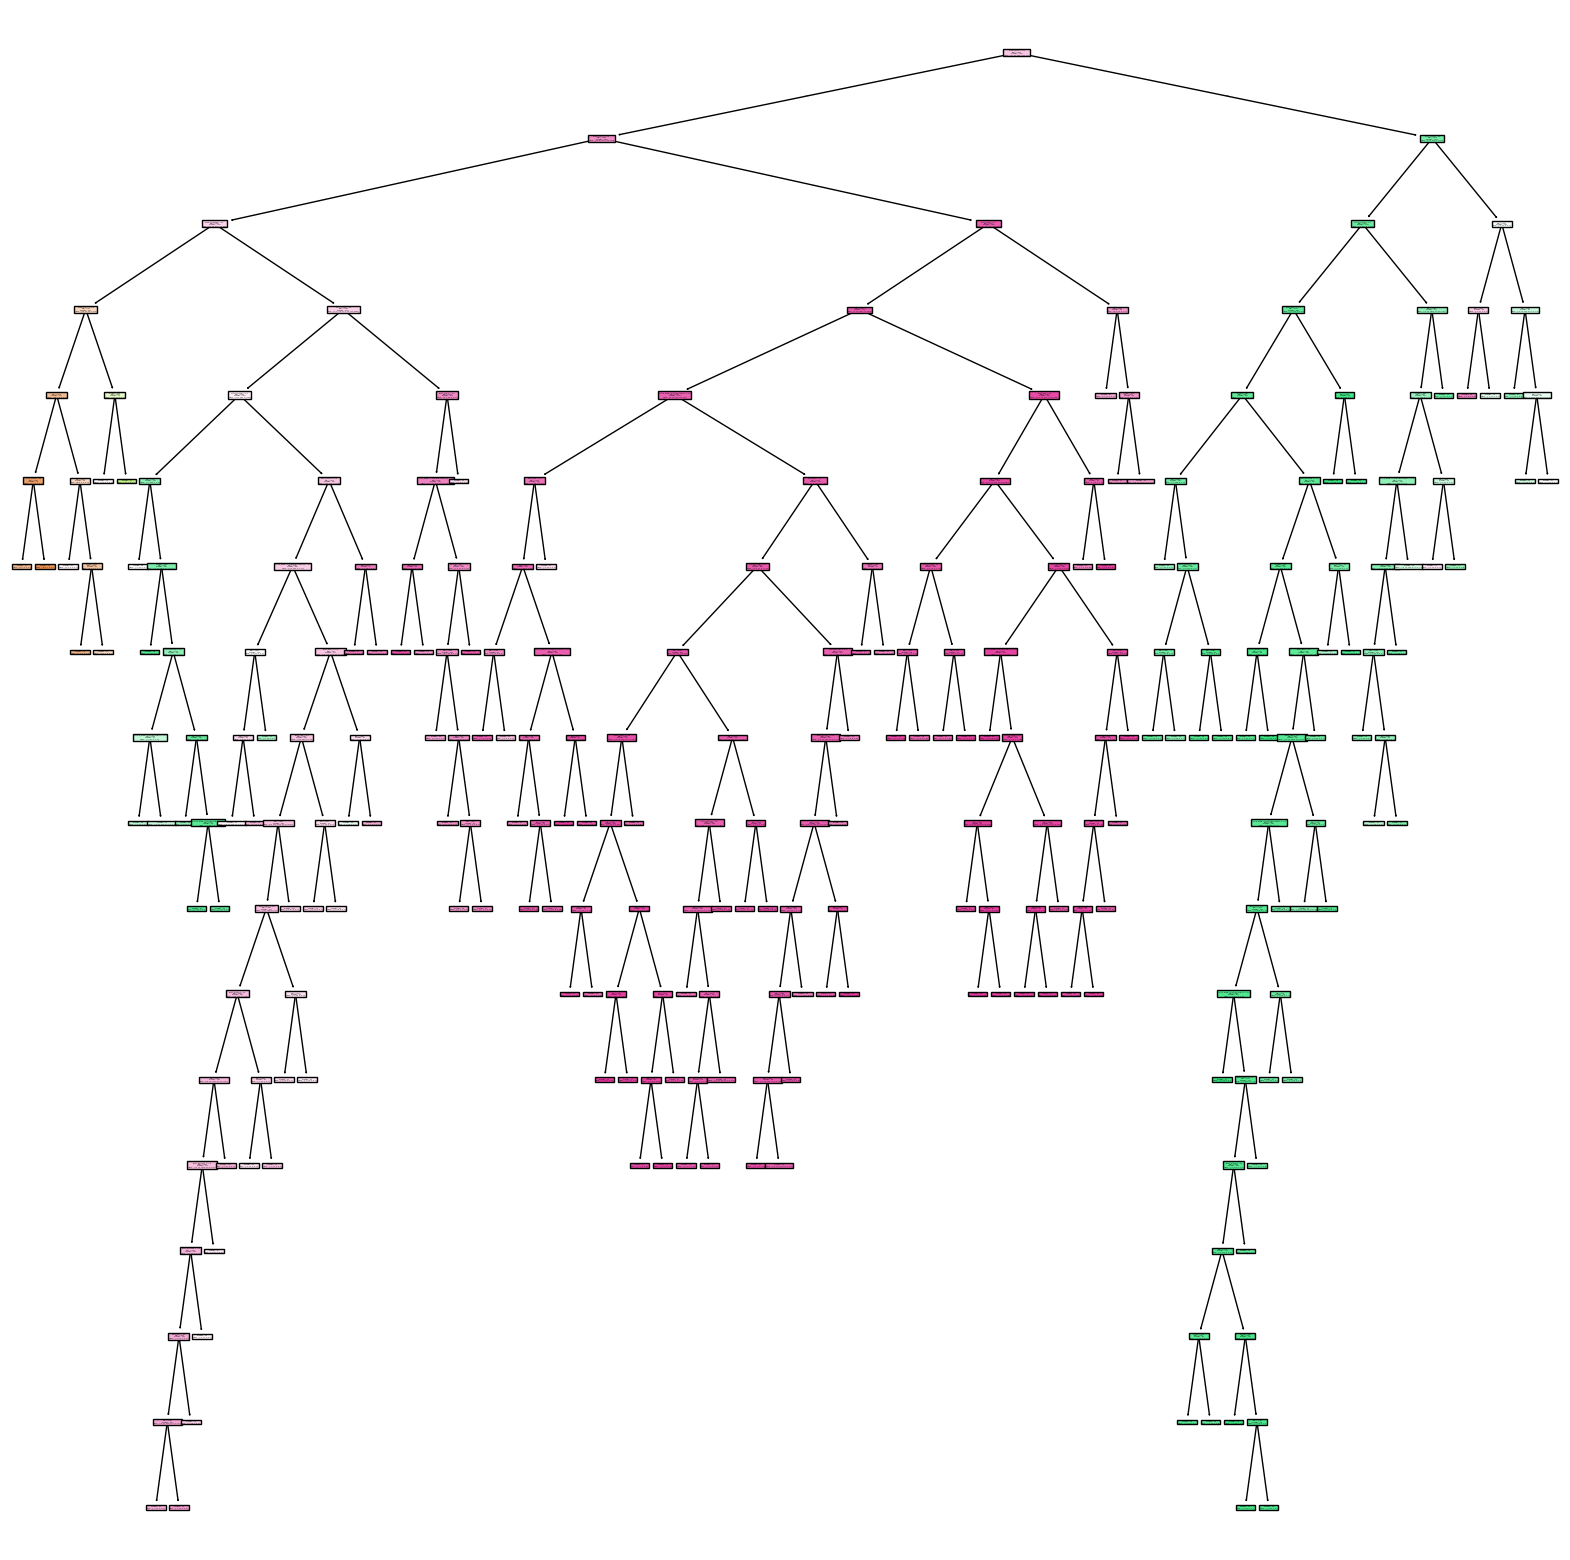

In [48]:
# importing all necessary libraries:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(min_samples_leaf=500, random_state=42)
model.fit(X_train_pre, Y_train_pre)
y_hat = model.predict(X_test_pre)

from sklearn.metrics import accuracy_score

acc_list = []
leaf_values = list(range(1, 26))

for leaf in leaf_values:
    model = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    model.fit(X_train_pre, Y_train_pre)
    y_hat = model.predict(X_test_pre)
    acc = accuracy_score(Y_test_pre, y_hat)
    acc_list.append(acc)

best_leaf = leaf_values[acc_list.index(max(acc_list))]
best_acc = max(acc_list)

print(f'Best min_sample_leaf value: {best_leaf} with Accuracy of {best_acc:.3f}')

plt.figure(figsize=(20, 20))
plot_tree(model, filled=True, feature_names=model.feature_names_in_)
plt.show()

In [49]:
for i in range(10):
    print(f"Predicted: {y_hat[i]} | Actual: {Y_test_pre.iloc[i]}")

Predicted: Black | Actual: Black
Predicted: White | Actual: White
Predicted: Black | Actual: White
Predicted: White | Actual: Black
Predicted: White | Actual: Unknown
Predicted: White | Actual: White
Predicted: White | Actual: White
Predicted: Black | Actual: White
Predicted: Black | Actual: Black
Predicted: White | Actual: White


In [50]:
count_blackpred_whiteactual = 0
for i in range(min(len(y_hat), len(Y_test_pre))):
    if y_hat[i] == 'Black' and Y_test_pre.iloc[i] == 'White':
        count_blackpred_whiteactual += 1

print("predicted Black, but was White in actual:", count_blackpred_whiteactual / min(len(y_hat), len(Y_test_pre)))


count_whitepred_blackactual = 0
for i in range(min(len(y_hat), len(Y_test_pre))):
    if y_hat[i] == 'White' and Y_test_pre.iloc[i] == 'Black':
        count_whitepred_blackactual += 1

print("predicted White, but was Black in actual:", count_whitepred_blackactual / min(len(y_hat), len(Y_test_pre)))

predicted Black, but was White in actual: 0.07710843373493977
predicted White, but was Black in actual: 0.11646586345381527


It appears 7% of the data's `VicRace` was predicted as 'Black' when the actual value was 'White'. 11.6% of the data's 'VicRace' was predicted as 'White' when the actual value was 'Black'. I'm not sure if there's some sort of bias here due to a large portion of the data having White victims, but it appears the model has a discrepancy in predicting these values. I will now see if prediction in Asian races with White (majority of data) has the same pattern. This isn't also conclusive due to not seeing all the other statistics (like crosstabs).

In [51]:
count_white_predicted_but_actual_asian = 0
count_asian_predicted_but_actual_white = 0
total_relevant = 0

for i in range(min(len(y_hat), len(Y_test_pre))):
    true_label = Y_test_pre.iloc[i]
    pred_label = y_hat[i]

    if true_label in ['White', 'Asian']:
        total_relevant += 1  # Only count samples that are actually White or Asian

        if true_label == 'Asian' and pred_label == 'White':
            count_white_predicted_but_actual_asian += 1

        elif true_label == 'White' and pred_label == 'Asian':
            count_asian_predicted_but_actual_white += 1

print("Predicted White but was actually Asian (as % of White+Asian):", count_white_predicted_but_actual_asian / total_relevant)
print("Predicted Asian but was actually White (as % of White+Asian):", count_asian_predicted_but_actual_white / total_relevant)


Predicted White but was actually Asian (as % of White+Asian): 0.022598870056497175
Predicted Asian but was actually White (as % of White+Asian): 0.0014124293785310734


In [52]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'White'])) & (predictions.isin(['Asian', 'White']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)

Predicted     Asian     White
Actual                       
Asian      0.157895  0.842105
White      0.001742  0.998258


In [53]:
white_count = (Y_test_pre == 'White').sum()
total_count = len(Y_test_pre)
white_ratio = white_count / total_count

print("Ratio of White victims over all victims:", white_ratio)

Ratio of White victims over all victims: 0.5461847389558233


We have that similar comparison here. Except, it's clear that there were more predictions for 'White' compared to that of 'Asians'. This might be due to there being a majority 'White' `VicRace` in he observations of the data (seen in code above). Let's try this with the other races crosstabbed with Asians to confirm these suspicions.

In [54]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


black_count = (Y_test_pre == 'Black').sum()
total_count = len(Y_test_pre)
black_ratio = black_count / total_count

print("\nRatio of Black victims over all victims:", black_ratio)

Predicted  Asian  Black
Actual                 
Asian       0.25   0.75
Black       0.00   1.00

Ratio of Black victims over all victims: 0.3718875502008032


In [55]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'American Indian or Alaskan Native'])) & (predictions.isin(['Asian', 'American Indian or Alaskan Native']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


native_count = (Y_test_pre == 'American Indian or Alaskan Native').sum()
total_count = len(Y_test_pre)
native_ratio = native_count / total_count

print("\nRatio of American Indian or Alaskan Native victims over all victims:", native_ratio)

Predicted                          American Indian or Alaskan Native  Asian
Actual                                                                     
American Indian or Alaskan Native                                1.0    0.0
Asian                                                            0.0    1.0

Ratio of American Indian or Alaskan Native victims over all victims: 0.04578313253012048


In [56]:
asian_count = (Y_test_pre == 'Asian').sum()
total_count = len(Y_test_pre)
asian_ratio = asian_count / total_count

print("\nRatio of Asian victims over all victims:", asian_ratio)


Ratio of Asian victims over all victims: 0.02248995983935743


What's interesting is we see a similar pattern for 'Black' populations in the data, corresponding to the pattern seen in the 'White''s crosstab. Then, we get to the Native Americans cross tab with 'Asian', where we see they're very disjoint in predictive to actual values. I looked at the total of each population out of all victims, and it seems the 'White' has the largest population, followed by 'Black', then by Native Americans, and finally 'Asian'. 

I believe there's a discrepancy in our model, or a large bias due to the lack of data on against-Asian crimes that needs to be addressed in the future. We'll most likely need to find a crime dataset that focuses on Asian populations. This highlights the importance of having inclusive datasets and not focusing on the majority populations. This also might mean that we need to report more crimes against Asian populations, or that most Asians aren't victims in crimes. More explanation is needed for this topic.

## **Training the POST-Covid Model:**

Best min_sample_leaf value: 12 with Accuracy of 0.747


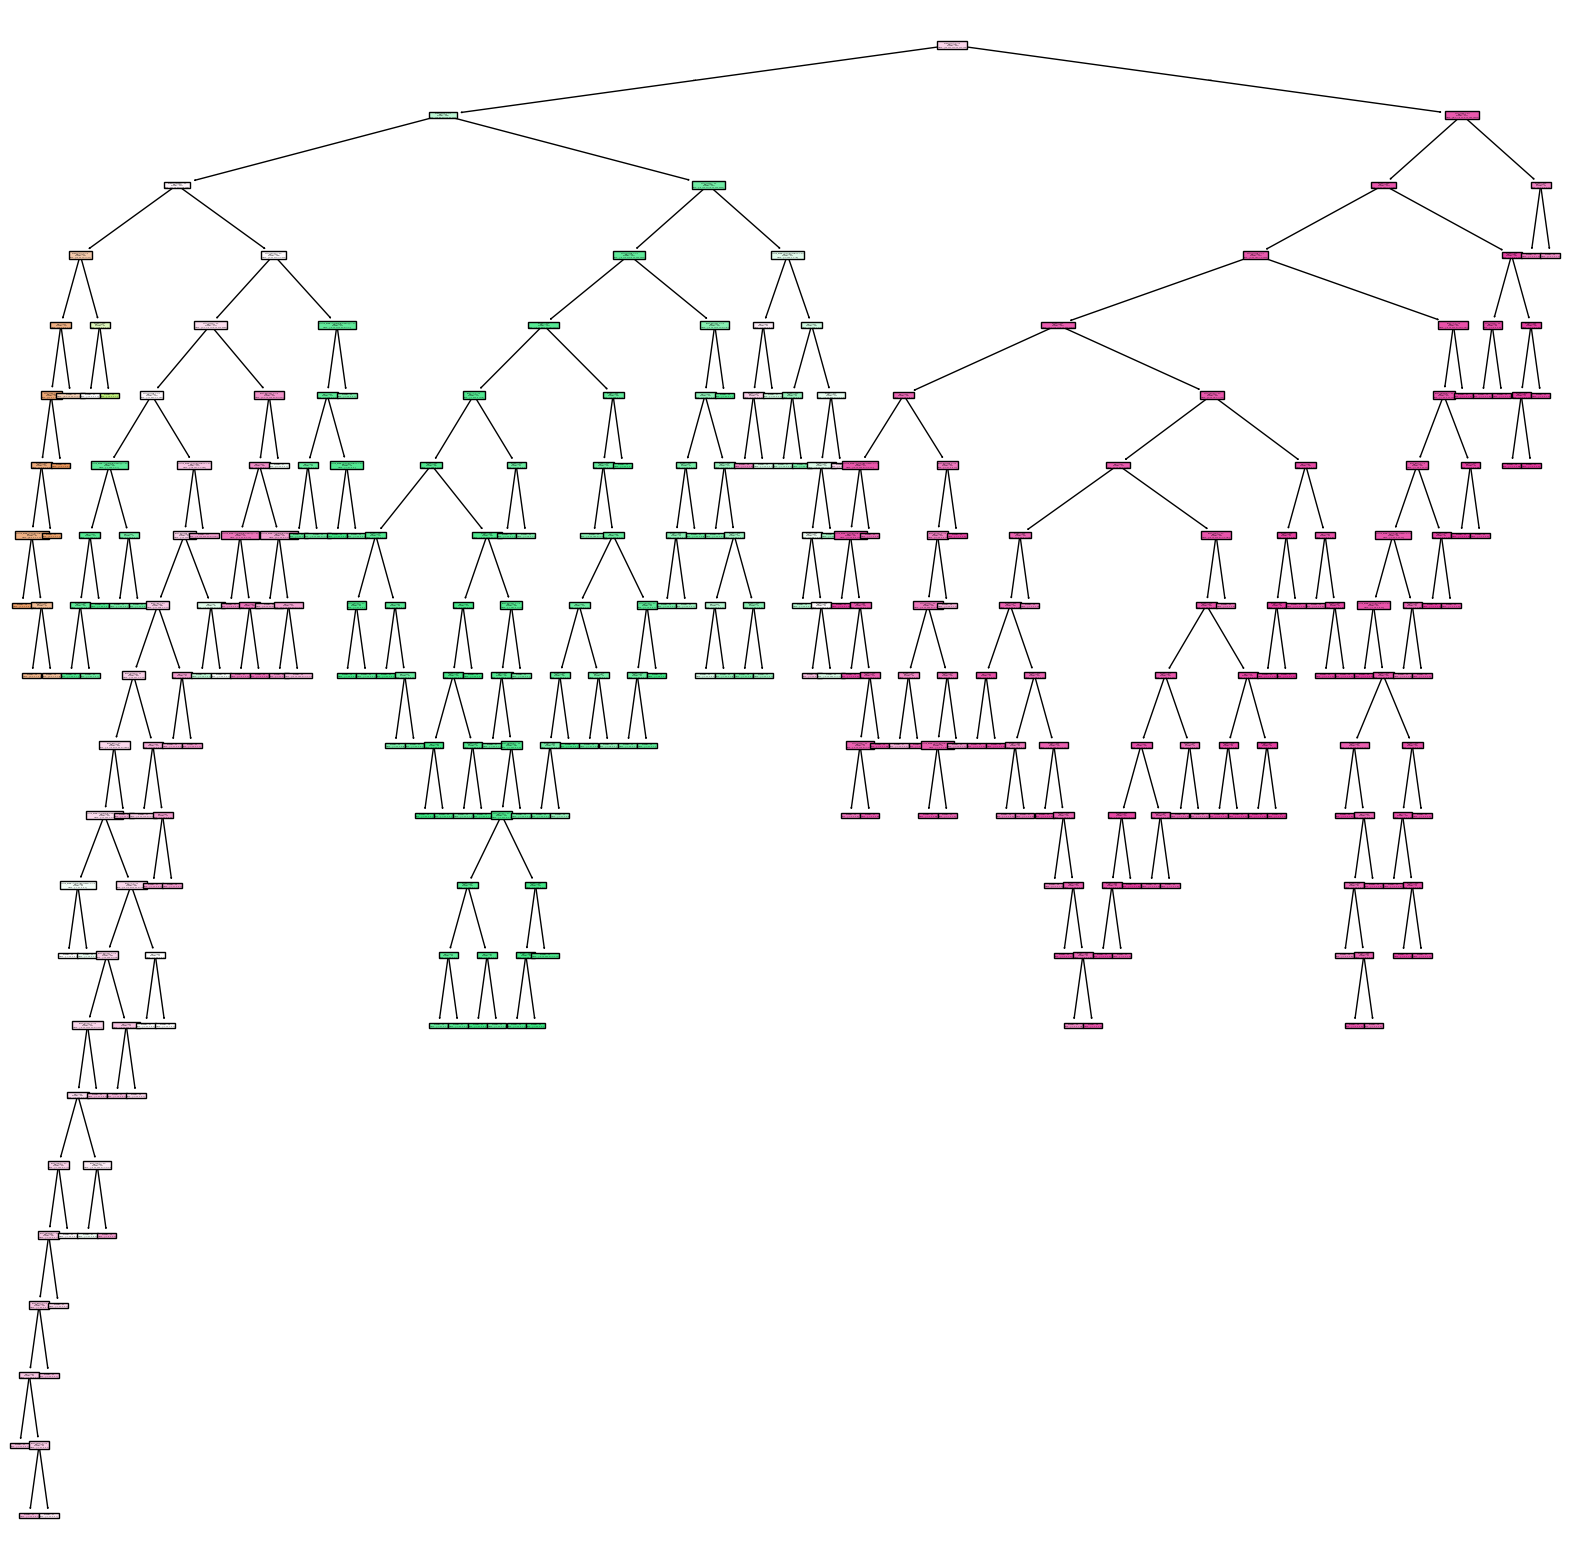

In [68]:
# importing all necessary libraries:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

model_post = DecisionTreeClassifier(min_samples_leaf=500, random_state=42)
model_post.fit(X_train_post, Y_train_post)
y_hat_post = model_post.predict(X_test_post)

from sklearn.metrics import accuracy_score

acc_list_post = []
leaf_values = list(range(1, 26))

for leaf in leaf_values:
    model_post = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    model_post.fit(X_train_post, Y_train_post)
    y_hat_post = model_post.predict(X_test_post)
    acc_post = accuracy_score(Y_test_post, y_hat_post)
    acc_list_post.append(acc_post)

best_leaf_post = leaf_values[acc_list_post.index(max(acc_list_post))]
best_acc_post = max(acc_list_post)

print(f'Best min_sample_leaf value: {best_leaf_post} with Accuracy of {best_acc_post:.3f}')

plt.figure(figsize=(20, 20))
plot_tree(model_post, filled=True, feature_names=model_post.feature_names_in_)
plt.show()


In [69]:
for i in range(10):
    print(f"Predicted: {y_hat_post[i]} | Actual: {Y_test_post.iloc[i]}")

Predicted: Black | Actual: Black
Predicted: Black | Actual: White
Predicted: White | Actual: White
Predicted: American Indian or Alaskan Native | Actual: American Indian or Alaskan Native
Predicted: White | Actual: Black
Predicted: White | Actual: White
Predicted: White | Actual: Unknown
Predicted: White | Actual: American Indian or Alaskan Native
Predicted: White | Actual: Black
Predicted: White | Actual: White


In [70]:
count_blackpred_whiteactual = 0
for i in range(min(len(y_hat_post), len(Y_test_post))):
    if y_hat_post[i] == 'Black' and Y_test_post.iloc[i] == 'White':
        count_blackpred_whiteactual += 1

print("predicted Black, but was White in actual:", count_blackpred_whiteactual / min(len(y_hat_post), len(Y_test_post)))


count_whitepred_blackactual = 0
for i in range(min(len(y_hat_post), len(Y_test_post))):
    if y_hat_post[i] == 'White' and Y_test_post.iloc[i] == 'Black':
        count_whitepred_blackactual += 1

print("predicted White, but was Black in actual:", count_whitepred_blackactual / min(len(y_hat_post), len(Y_test_post)))

predicted Black, but was White in actual: 0.09174917491749175
predicted White, but was Black in actual: 0.0924092409240924


In [71]:
count_white_predicted_but_actual_asian = 0
count_asian_predicted_but_actual_white = 0
total_relevant = 0

for i in range(min(len(y_hat_post), len(Y_test_post))):
    true_label = Y_test_post.iloc[i]
    pred_label = y_hat_post[i]

    if true_label in ['White', 'Asian']:
        total_relevant += 1  # Only count samples that are actually White or Asian

        if true_label == 'Asian' and pred_label == 'White':
            count_white_predicted_but_actual_asian += 1

        elif true_label == 'White' and pred_label == 'Asian':
            count_asian_predicted_but_actual_white += 1

print("Predicted White but was actually Asian (as % of White+Asian):", count_white_predicted_but_actual_asian / total_relevant)
print("Predicted Asian but was actually White (as % of White+Asian):", count_asian_predicted_but_actual_white / total_relevant)


Predicted White but was actually Asian (as % of White+Asian): 0.022538552787663108
Predicted Asian but was actually White (as % of White+Asian): 0.0035587188612099642


In [72]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'White'])) & (predictions.isin(['Asian', 'White']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)

Predicted     Asian     White
Actual                       
Asian      0.208333  0.791667
White      0.004608  0.995392


In [73]:
white_count = (y_hat_post == 'White').sum()
total_count = len(y_hat_post)
white_ratio = white_count / total_count

print("Ratio of White victims over all victims:", white_ratio)

Ratio of White victims over all victims: 0.5570957095709571


In [75]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


black_count = (Y_test_post == 'Black').sum()
total_count = len(Y_test_post)
black_ratio = black_count / total_count

print("\nRatio of Black victims over all victims:", black_ratio)

Predicted     Asian     Black
Actual                       
Asian      0.357143  0.642857
Black      0.006977  0.993023

Ratio of Black victims over all victims: 0.37755775577557754


In [78]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'American Indian or Alaskan Native'])) & (predictions.isin(['Asian', 'American Indian or Alaskan Native']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


native_count = (Y_test_post == 'American Indian or Alaskan Native').sum()
total_count = len(Y_test_post)
native_ratio = native_count / total_count

print("\nRatio of American Indian or Alaskan Native victims over all victims:", native_ratio)

Predicted                          American Indian or Alaskan Native  Asian
Actual                                                                     
American Indian or Alaskan Native                                1.0    0.0
Asian                                                            0.0    1.0

Ratio of American Indian or Alaskan Native victims over all victims: 0.042244224422442245


In [81]:
asian_count = (Y_test_post == 'Asian').sum()
total_count = len(Y_test_post)
asian_ratio = asian_count / total_count

print("\nRatio of Asian victims over all victims:", asian_ratio)


Ratio of Asian victims over all victims: 0.02178217821782178
